# Modelling

## Library

In [1]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Read data

In [2]:
data = pd.read_csv("https://www.mldata.io/download-csv-weka/german_credit_data/")

## Preparing data for modeling

### Variable types

#### Continuous  
- duration
- credit_amount
- age
- installment_rate
- present_residence
- dependents
- existing_credits


#### Nominal  
- credit_history
- purpose
- personal
- other_debtors
- property
- other_installment_plans
- housing
- job
- telephone
- foreign_worker
- present_employment

#### Ordinal
- checking_account_status
- savings  

in both cases amounts can be put in order, but having no account should be treated as different variable during encoding

## Change name 

In [3]:
data.telephone = data.telephone.map({"A191": 0, "A192": 1})
data.foreign_worker = data.foreign_worker.map({"A201": 1, "A202": 0})
data.job = data.job.map({"A171" : "unemployed/unskilled","A172": "unskilled-resident", "A173": "skilled_employee","A174": "management/self-employed"})
data.housing = data.housing.map({'A151' : 'rent', 'A152' : 'own', 'A153' : 'free'})
data.purpose = data.purpose.map({'A40': 'new car', 'A41': 'used car', 'A42': 'furniture/equipment', 'A43': 'radio/television', 'A44': 'domestic appliances', 'A45': 'repairs', 'A46': 'education', 'A47': 'vacation', 'A48':'retraining',
'A49': 'business', 'A410': 'others'})
data.other_debtors = data.other_debtors.map({'A101': 'none', 'A102': 'co-applicant', 'A103': 'guarantor'})
data.other_installment_plans = data.other_installment_plans.map({'A141': 'bank', 'A142': 'stores', 'A143': 'none'})

In [4]:
data.customer_type.replace([1,2], [1,0], inplace=True)
data.customer_type.value_counts()

1    700
0    300
Name: customer_type, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   checking_account_status  1000 non-null   object 
 1   duration                 1000 non-null   int64  
 2   credit_history           1000 non-null   object 
 3   purpose                  1000 non-null   object 
 4   credit_amount            1000 non-null   float64
 5   savings                  1000 non-null   object 
 6   present_employment       1000 non-null   object 
 7   installment_rate         1000 non-null   float64
 8   personal                 1000 non-null   object 
 9   other_debtors            1000 non-null   object 
 10  present_residence        1000 non-null   float64
 11  property                 1000 non-null   object 
 12  age                      1000 non-null   float64
 13  other_installment_plans  1000 non-null   object 
 14  housing                  

## Handling outliers

As said earlier, only observable outliers can appear in credit_ammount column. Let's take a closer look.



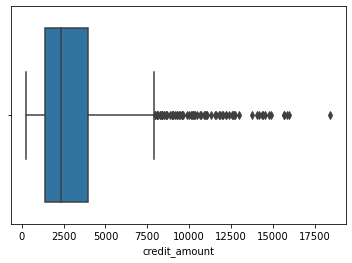

In [6]:
sns.boxplot(x = data['credit_amount'])

In [7]:
data_out = data[data.credit_amount>8000]
data_out.customer_type.mean()

0.45714285714285713

In [8]:
data_out = data[data.credit_amount>10000]
data_out.customer_type.mean()

0.4

In [9]:
data_out = data[data.credit_amount>13000]
data_out.customer_type.mean()

0.3076923076923077

so the higher as outliers go the less likely it is that credit was paid

In [10]:
data.customer_type.mean()

0.7

In [11]:
data[data.credit_amount<10000].customer_type.mean()

0.7125

In [12]:
len(data[data.credit_amount<10000])

960

Still these outliers don't differentiate distribution of customer_type that much, so keeping them might provide some valuable information and deffinately won't affect modeling badly.

## Adding gender

In [13]:
data['sex'] = data.personal.apply(lambda x: 1 if x in ['A91', 'A93', 'A94'] else 0) # male = 1, female = 0

## Adding info abour account presence

In [14]:
data['checking_account_exists'] = np.where(data['checking_account_status']=='A14', 0, 1)
data['savings_account_exists'] = np.where(data['savings']=='A65', 0, 1)

## Divide data into train and test set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('customer_type', axis=1), data.customer_type, test_size=0.3)

## Encoding function

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   checking_account_status  1000 non-null   object 
 1   duration                 1000 non-null   int64  
 2   credit_history           1000 non-null   object 
 3   purpose                  1000 non-null   object 
 4   credit_amount            1000 non-null   float64
 5   savings                  1000 non-null   object 
 6   present_employment       1000 non-null   object 
 7   installment_rate         1000 non-null   float64
 8   personal                 1000 non-null   object 
 9   other_debtors            1000 non-null   object 
 10  present_residence        1000 non-null   float64
 11  property                 1000 non-null   object 
 12  age                      1000 non-null   float64
 13  other_installment_plans  1000 non-null   object 
 14  housing                  

In [17]:
import category_encoders as ce
class Error(Exception):
    pass
class NonMatchingLengthsError(Error):
    pass

In [18]:
def multiEnc(X_train, X_test, target_train, cols, encodings):
    """
    Lista znaków do "encodings":
        d - backward difference
        n - base N
        b - binary
        c - cat boost
        # - hashing
        h - helmert
        j - James-Stein
        l - leave one out
        m - m-estimate
        1 - one-hot
        o - ordinal
        p - polynomial
        s - sum coding
        t - target encoding
        w - weight of evidence
    """
    ce_map = {"d": ce.backward_difference.BackwardDifferenceEncoder,
             "n": ce.basen.BaseNEncoder,
             "b": ce.binary.BinaryEncoder,
             "c": ce.cat_boost.CatBoostEncoder,
             "#": ce.hashing.HashingEncoder,
             "h": ce.helmert.HelmertEncoder,
             "j": ce.james_stein.JamesSteinEncoder,
             "l": ce.leave_one_out.LeaveOneOutEncoder,
             "m": ce.m_estimate.MEstimateEncoder,
             "1": ce.one_hot.OneHotEncoder,
             "o": ce.ordinal.OrdinalEncoder,
             "p": ce.polynomial.PolynomialEncoder,
             "s": ce.sum_coding.SumEncoder,
             "t": ce.target_encoder.TargetEncoder,
             "w": ce.woe.WOEEncoder}
    try:
        if len(cols)!=len(encodings):
            raise(NonMatchingLengthsError)
    except NonMatchingLengthsError:
        print("Lengths do not match")
        return None
    e=0
    for c in cols:
        if X_train[c].dtypes=='object':
            enc=ce_map[encodings[e]](cols=c)
            enc=enc.fit(X_train, target_train)
            X_train=enc.transform(X_train)
            X_test=enc.transform(X_test)
        e=e+1
    return (X_train, X_test)

In [19]:
#X_train, X_test = multiEnc(X_train, X_test, y_train ,['job'], ['1'])

In [20]:
X_train.head(4)

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,sex,checking_account_exists,savings_account_exists
36,A14,48,A34,education,6110.0,A61,A73,1.0,A93,none,...,bank,free,1.0,skilled_employee,1,1,1,1,0,1
381,A12,18,A32,used car,12976.0,A61,A71,3.0,A92,none,...,none,free,1.0,management/self-employed,1,1,1,0,1,1
0,A11,6,A34,radio/television,1169.0,A65,A75,4.0,A93,none,...,none,own,2.0,skilled_employee,1,1,1,1,1,0
531,A12,15,A32,new car,2631.0,A62,A73,2.0,A92,none,...,none,rent,2.0,skilled_employee,1,1,1,0,1,1


## Normalizing continous variables

In [21]:
from sklearn import preprocessing 

def normalize(df, columns):
    for column in columns:
        x = df[[column]].values.astype(float)
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df[[column]] = x_scaled
    return df

In [22]:
data = normalize(data, ['duration', 'credit_amount', 'age', 'installment_rate', 'present_residence', 'dependents', 'existing_credits'])

## Create generic functions to add models and make a Cross-Validation

In [55]:
from abc import (ABC, 
                 abstractmethod, 
                 abstractproperty)
from typing import Any
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier # Inna paczka niż sklearn!
import xgboost as xgb


class Builder(ABC):

    @abstractproperty
    def product(self) -> None:
        pass
    
    
class Product():

    def __init__(self) -> None:
        self.parts = []

    def add(self, part: Any) -> None:
        self.parts.append(part)

    def list_parts(self):
        return self.parts


class ConcreteBuilder(Builder):

    def __init__(self) -> None:

        self.reset()

    def reset(self) -> None:
        self._product = Product()

    @property
    def product(self) -> Product:

        product = self._product
        self.reset()
        return product

    def _add_model(self, model_type: str, params: dict):
        if model_type == 'logistic regression':
            self._logistic_regression(params)
        if model_type == 'decision tree':
            self._decision_tree(params)
        if model_type == 'svm':
            self._svm(params)
        if model_type == 'naive bayes':
            self._naive_bayes(params)
        if model_type == 'random forest':
            self._random_forest(params)
        if model_type == 'Ada boost':
            self._ada_boost(params)
        if model_type == 'gradient boost':
            self._gradient_boost(params)
        if model_type == 'xgboost':
            self._xgboost(params)
        
    def _logistic_regression(self, params: dict):
        lr = LogisticRegression()
        
        return self._product.add(lr)
    
    def _decision_tree(self, params: dict):
        
        dt = DecisionTreeClassifier()
        
        dt_params = {'criterion': dt.criterion}
        
        return self._product.add(dt)

    def _svm(self, params: dict):
        svm = SVC()
        
        return self._product.add(svm)
    
    def _naive_bayes(self, params: dict):
        nb = GaussianNB()

        return self._product.add(nb)
    
    def _random_forest(self, params: dict):
        
        rf = RandomForestClassifier(n_estimators=1000, # Ilość słabych estymatorów
                                          max_depth=2, # Maksymalna wysokość drzewa w słabym estymatorze
                                          min_samples_split = 2, # Minimalna ilość obserwacji wymagana do podziału węzła
                                          max_features = 3, # Maksymalna ilość zmiennych brana pod uwagę przy podziale węzła
                                          random_state=0,
                                          n_jobs = -1)
        return self._product.add(rf)
        
    def _ada_boost(self, params: dict):
        ada = AdaBoostClassifier(random_state=1)
    
        return self._product.add(ada)
    
    def _gradient_boost(self, params: dict):
        gb= GradientBoostingClassifier(random_state=1,
                                  learning_rate=0.01)
        return self._product.add(gb)
    
    def _xgboost(self, params: dict):
        
        xg=XGBClassifier()
        return self._product.add(xg)

class Director:

    def __init__(self) -> None:
        self._builder = None

    @property
    def builder(self) -> Builder:
        return self._builder

    @builder.setter
    def builder(self, builder: Builder) -> None:

        self._builder = builder


    def add_model(self, model_type, params):
        return self.builder._add_model(model_type, params)

    def add_all_models(self):
        self.add_model('logistic regression', {})
        self.add_model('decision tree', {})
        self.add_model('svm', {})
        self.add_model('naive bayes', {})
        self.add_model('random forest', {})
        self.add_model('ada boost', {})
        self.add_model('gradient boost', {})
        self.add_model('xgboost', {})
        return builder.product.list_parts()
    
    def get_all_models(self, metric_name: str = ''):
        parts =  builder.product.list_parts()
        return parts

In [56]:
director = Director()
builder = ConcreteBuilder()
director.builder = builder

In [57]:
director.add_model('logistic regression', {})
director.add_model('decision tree', {})
director.add_model('svm', {})
director.add_model('naive bayes', {})
director.add_model('random forest', {})
director.add_model('ada boost', {})
director.add_model('gradient boost', {})
director.add_model('xgboost', {})

In [58]:
models = director.get_all_models()

In [59]:
all_models = director.add_all_models()

## Compare models

In [28]:
X_train.head(4)

,checking_account_status,duration,credit_history,purpose,credit_amount,savings,present_employment,installment_rate,personal,other_debtors,...,other_installment_plans,housing,existing_credits,job,dependents,telephone,foreign_worker,sex,checking_account_exists,savings_account_exists
36,A14,48,A34,education,6110.0,A61,A73,1.0,A93,none,...,bank,free,1.0,skilled_employee,1,1,1,1,0,1
381,A12,18,A32,used car,12976.0,A61,A71,3.0,A92,none,...,none,free,1.0,management/self-employed,1,1,1,0,1,1
0,A11,6,A34,radio/television,1169.0,A65,A75,4.0,A93,none,...,none,own,2.0,skilled_employee,1,1,1,1,1,0
531,A12,15,A32,new car,2631.0,A62,A73,2.0,A92,none,...,none,rent,2.0,skilled_employee,1,1,1,0,1,1


In [29]:
y_train.head(4)

36     1
381    0
0      1
531    0
Name: customer_type, dtype: int64

In [30]:
from typing import List


def compare_models(models_list: List, X_train, y_train, X_test, y_test, categorical_variables, method):
    results = dict()
    
    df_train, df_test = multiEnc(X_train, X_test, y_train, categorical_variables, len(categorical_variables) * method)
    
    
    for model in models_list:
        
        training = model.fit(df_train, y_train)
        score = training.score(df_test, y_test)
        results[model] = score
        
    return results, df_train, df_test

In [31]:
categorical_variables = ['credit_history', 'purpose', 'personal', 'other_debtors', 'property', 
                        'other_installment_plans', 'housing' , 'job', 'telephone', 'foreign_worker', 
                        'present_employment', 'checking_account_status', 'savings'] 

In [80]:
def best_model(results: dict):
    best_model_val = 0
    suma = 0
    it = 0
    for key,val in results.items():
        it = it + 1
        suma = suma + val
        if val > best_model_val:
            best_model = key
            best_model_val = val

    print("Mean: " + str(suma/it))
    return best_model

In [38]:
from plot_metric.functions import BinaryClassification
from sklearn.metrics import roc_auc_score

def plot_roc(model, df_test, y_test):
    y_pred = model.predict_proba(df_test)[:,1]
    
    # Visualisation with plot_metric
    bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

    # Figures
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()
    
    print(model, roc_auc_score(y_test, y_pred, multi_class="ovo", average="weighted"))

### One-hot encoding

This method produces a lot of columns that *slows down the learning* significantly if the number of the category is very high for the feature.

**Scikit-learn has OneHotEncoder for this purpose, but it does not create an additional feature column (another code is needed, as shown in the below code sample).**


We can represent all categories by **N-1 (N= No of Category)** as that is sufficient to encode the one that is not included. Usually, for Regression, we use **N-1** (drop first or last column of One Hot Coded new feature ), but for classification, the recommendation is to use all N columns without as most of the tree-based algorithm builds a tree based on all available



In tree-based methods, we will never consider that additional label if we dropp. Thus, if we use the categorical variables in a tree-based learning algorithm, it is good practice to encode it into **N binary variables** and doesn’t drop.

In [92]:
results, df_train, df_test = compare_models(models, X_train, y_train, X_test, y_test, categorical_variables, '1')
results

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): 0.78,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'): 0.7,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,


In [93]:
model = best_model(results)
model

Mean: 0.7280952380952381


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

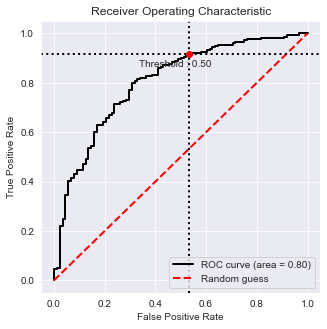

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.8029052315608919


In [94]:
plot_roc(model, df_test, y_test)

### Ordinal encoding

In [84]:
results, df_train, df_test = compare_models(models, X_train, y_train, X_test, y_test, categorical_variables, 'o')
results

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): 0.7366666666666667,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'): 0.7166666666666667,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random

In [85]:
model = best_model(results)
model

Mean: 0.7180952380952382


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

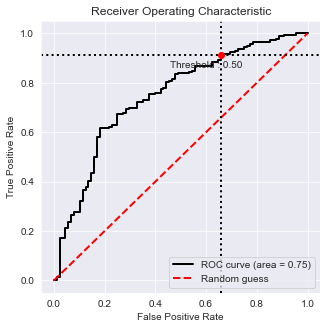

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.7470518867924528


In [67]:
plot_roc(model, df_test, y_test)

### Binary encoding

For Binary encoding, one has to follow the following steps:
1. The categories are first converted to numeric order starting from 1 (order is created as categories appear in a dataset and do not mean any ordinal nature)
2. Then those integers are converted into binary code, so for example 3 becomes 011, 4 becomes 100
3. Then the digits of the binary number form separate columns.

In [86]:
results, df_train, df_test = compare_models(models, X_train, y_train, X_test, y_test, categorical_variables, 'b')
results

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): 0.76,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'): 0.7133333333333334,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, s

In [87]:
model = best_model(results)
model

Mean: 0.7271428571428571


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

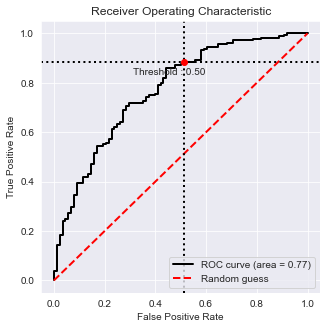

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.7698863636363638


In [70]:
plot_roc(model, df_test, y_test)

### Weigth of Evidence encoding

Weight of Evidence (WoE) is a measure of the “strength” of a grouping technique to separate good and bad.

WoE is well suited for **Logistic Regression** because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in Logistic Regression, the predictors are all prepared and coded to the same scale. The parameters in the linear logistic regression equation can be directly compared.

#### Pros and cons

The WoE transformation has (at least) three advantage:  
1) It can transform an independent variable so that it establishes a monotonic relationship to the dependent variable. It does more than this — to secure monotonic relationship it would be enough to “recode” it to any ordered measure (for example 1,2,3,4…), but the WoE transformation orders the categories on a “logistic” scale which is natural for Logistic Regression  
2) For variables with too many (sparsely populated) discrete values, these can be grouped into categories (densely populated), and the WoE can be used to express information for the whole category  
3) The (univariate) effect of each category on the dependent variable can be compared across categories and variables because WoE is a standardized value (for example you can compare WoE of married people to WoE of manual workers)  
It also has (at least) three drawbacks:
1) Loss of information (variation) due to binning to a few categories  
2) It is a “univariate” measure, so it does not take into account the correlation between independent variables  
3) It is easy to manipulate (over-fit) the effect of variables according to how categories are created  


In [88]:
results, df_train, df_test = compare_models(models, X_train, y_train, X_test, y_test, categorical_variables, 'w')
results

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): 0.7866666666666666,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'): 0.67,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, s

In [89]:
model = best_model(results)
model

Mean: 0.7247619047619047


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

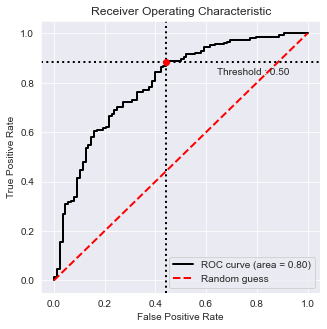

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.7950257289879931


In [73]:
plot_roc(model, df_test, y_test)

### James-Stein encoding


For feature value, James-Stein estimator returns a weighted average of:
The mean target value for the observed feature value.
The mean target value (regardless of the feature value).

The James-Stein encoder shrinks the average toward the overall average. It is a target based encoder. James-Stein estimator has, however, one practical limitation — it was defined only for *normal distributions*.

In [90]:
results, df_train, df_test = compare_models(models, X_train, y_train, X_test, y_test, categorical_variables, 'j')
results

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): 0.7433333333333333,
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'): 0.6833333333333333,
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random

In [91]:
model = best_model(results)
model

Mean: 0.7195238095238096


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

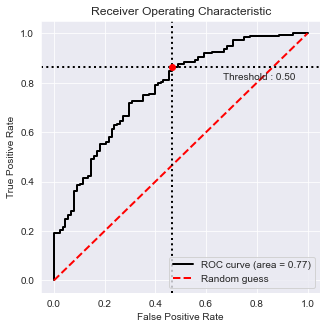

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None) 0.7710656089193825


In [76]:
plot_roc(model, df_test, y_test)

## Cross validation

https://scikit-learn.org/stable/modules/cross_validation.html?fbclid=IwAR37ckzi8ZtZ_L7RRl730BbA1i6IXs60nQVap8uW4InVppo9zlvxcPWRMFU

![<Photo>](images/image.png)

In [178]:
from typing import List
from sklearn import metrics
from sklearn.model_selection import cross_val_score


def compare_models_CV(models_list: List, X_train, y_train, categorical_variables, method, cv: int, scoring: str):
    results = dict()
    
    df_train, df_test = multiEnc(X_train, X_test, y_train, categorical_variables, len(categorical_variables) * method)
    
    
    
    for model in models_list:
        
        score =cross_val_score(model, df_train, y_train, cv=cv, scoring=scoring)
        results[model] = score
        
    return results

In [179]:
compare_models_CV(models, X_train, y_train, categorical_variables, '1', 5, 'f1_macro')

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): array([0.65720336, 0.66860725, 0.6556713 , 0.67058824, 0.74716202]),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'): array([0.66308943, 0.60335058, 0.63851628, 0.66625967, 0.60268318]),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_functi

In [230]:
compare_models_CV(models, X_train, y_train, categorical_variables, 'l', 10, 'f1_macro')

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False): array([0.55357143, 0.6478248 , 0.5146379 , 0.49712644, 0.50892857,
        0.54741379, 0.44683908, 0.46778711, 0.5146379 , 0.40677966]),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'): array([0.61427447, 0.72163743, 0.66856061, 0.65      , 0.64756653,
        0.61400144, 0.66856061

## Conclusions

For nominal columns try OneHot, Hashing, LeaveOneOut, and Target encoding. Avoid OneHot for high cardinality columns and decision tree-based algorithms.

For ordinal columns try Ordinal (Integer), Binary, OneHot, LeaveOneOut, and Target. Helmert, Sum, BackwardDifference and Polynomial are less likely to be helpful, but if you have time or theoretic reason you might want to try them.

![<Photo>](images/table.png)